In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from transformers import RobertaForTokenClassification, RobertaTokenizerFast
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import json

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume the dataframes are read from CSV files
entity_df = pd.read_csv('/kaggle/input/business-json/Knowledge.csv')
sentences_df = pd.read_csv('/kaggle/input/business-json/Test (1).csv')

# Load the fast tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Load model
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=4)
model.to(device)  # Move the model to the GPU if available

# Freeze all the parameters except the classification head
for param in model.base_model.parameters():
    param.requires_grad = False

# Set the model to evaluation mode (optional, only if you are evaluating)
model.eval()

print("Model Loaded and Base Model Frozen")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded and Base Model Frozen


In [4]:
import ast

class NERDataset(Dataset):
    def __init__(self, sentences_df, tokenizer):
        self.sentences = sentences_df['text'].tolist()
        self.entities = [self.parse_entities(e) for e in sentences_df['entities'].tolist()]
        self.tokenizer = tokenizer
        self.ids = sentences_df['sentence_id'].tolist()
    def parse_entities(self, entity_str):
        # Convert the string representation of the list to an actual list
        entity_list = ast.literal_eval(entity_str)
        # Remove extra double quotes from mentions
        for entity in entity_list:
            entity['mention'] = entity['mention'].replace('""', '"').strip('"')
        return entity_list

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        entities = self.entities[idx]
        sentence_id = self.ids[idx]
        tokens = self.tokenizer(sentence, return_offsets_mapping=True, truncation=True, max_length=24)

        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        offset_mapping = tokens['offset_mapping']

        labels = np.zeros(len(input_ids))

        for entity in entities:
            mention = entity['mention']
            start_idx = sentence.find(mention)
            if start_idx == -1:
                continue
            end_idx = start_idx + len(mention)

            for i, (start, end) in enumerate(offset_mapping):
                if start <= start_idx < end:
                    labels[i] = 1  # B-Entity
                if start < end_idx <= end:
                    labels[i] = 2  # I-Entity

        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(labels, dtype=torch.long),
            'sentence_id': sentence_id
        }
    
    
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    sentence_ids = [item['sentence_id'] for item in batch]
    # Pad sequences to the same length
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Ignore index for labels

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels_padded,
        'sentence_id': sentence_ids
    }



# Create dataset and dataloader
dataset = NERDataset(sentences_df, tokenizer)
# Update your DataLoader to use the custom collate function
dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

# Split the dataset into train and validation sets (80:20)
train_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader objects for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [5]:
optimizer = AdamW(model.parameters(), lr=3e-5)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [6]:
num_epochs = 250
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = eval_epoch(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Training Loss: {train_loss:.8f}')
    print(f'Validation Loss: {val_loss:.8f}')


Epoch 1/250


100%|██████████| 263/263 [00:03<00:00, 78.53it/s]


Training Loss: 1.33184126
Validation Loss: 1.26747587
Epoch 2/250


100%|██████████| 263/263 [00:03<00:00, 76.09it/s]


Training Loss: 1.22926654
Validation Loss: 1.17216372
Epoch 3/250


100%|██████████| 263/263 [00:03<00:00, 80.66it/s]


Training Loss: 1.13881831
Validation Loss: 1.08875397
Epoch 4/250


100%|██████████| 263/263 [00:03<00:00, 79.51it/s]


Training Loss: 1.06266198
Validation Loss: 1.01578463
Epoch 5/250


100%|██████████| 263/263 [00:03<00:00, 81.45it/s]


Training Loss: 0.99892787
Validation Loss: 0.95227906
Epoch 6/250


100%|██████████| 263/263 [00:03<00:00, 80.67it/s]


Training Loss: 0.93671904
Validation Loss: 0.89702715
Epoch 7/250


100%|██████████| 263/263 [00:03<00:00, 81.59it/s]


Training Loss: 0.88758793
Validation Loss: 0.84898366
Epoch 8/250


100%|██████████| 263/263 [00:03<00:00, 80.87it/s]


Training Loss: 0.84581091
Validation Loss: 0.80747207
Epoch 9/250


100%|██████████| 263/263 [00:03<00:00, 81.63it/s]


Training Loss: 0.80803145
Validation Loss: 0.77115602
Epoch 10/250


100%|██████████| 263/263 [00:03<00:00, 80.49it/s]


Training Loss: 0.77484990
Validation Loss: 0.73916291
Epoch 11/250


100%|██████████| 263/263 [00:03<00:00, 80.71it/s]


Training Loss: 0.75002584
Validation Loss: 0.71087701
Epoch 12/250


100%|██████████| 263/263 [00:03<00:00, 80.57it/s]


Training Loss: 0.71831906
Validation Loss: 0.68541886
Epoch 13/250


100%|██████████| 263/263 [00:03<00:00, 79.67it/s]


Training Loss: 0.69284213
Validation Loss: 0.66241509
Epoch 14/250


100%|██████████| 263/263 [00:03<00:00, 80.12it/s]


Training Loss: 0.67354365
Validation Loss: 0.64158914
Epoch 15/250


100%|██████████| 263/263 [00:03<00:00, 79.90it/s]


Training Loss: 0.64906042
Validation Loss: 0.62250671
Epoch 16/250


100%|██████████| 263/263 [00:03<00:00, 80.55it/s]


Training Loss: 0.63495774
Validation Loss: 0.60486080
Epoch 17/250


100%|██████████| 263/263 [00:03<00:00, 80.53it/s]


Training Loss: 0.62091618
Validation Loss: 0.58835020
Epoch 18/250


100%|██████████| 263/263 [00:03<00:00, 81.54it/s]


Training Loss: 0.60246176
Validation Loss: 0.57287318
Epoch 19/250


100%|██████████| 263/263 [00:03<00:00, 80.04it/s]


Training Loss: 0.58557901
Validation Loss: 0.55828463
Epoch 20/250


100%|██████████| 263/263 [00:03<00:00, 81.06it/s]


Training Loss: 0.56731397
Validation Loss: 0.54447654
Epoch 21/250


100%|██████████| 263/263 [00:03<00:00, 81.00it/s]


Training Loss: 0.56222007
Validation Loss: 0.53141469
Epoch 22/250


100%|██████████| 263/263 [00:03<00:00, 79.91it/s]


Training Loss: 0.54816028
Validation Loss: 0.51896516
Epoch 23/250


100%|██████████| 263/263 [00:03<00:00, 81.31it/s]


Training Loss: 0.53411634
Validation Loss: 0.50707209
Epoch 24/250


100%|██████████| 263/263 [00:03<00:00, 81.41it/s]


Training Loss: 0.52129856
Validation Loss: 0.49564651
Epoch 25/250


100%|██████████| 263/263 [00:03<00:00, 80.92it/s]


Training Loss: 0.51490281
Validation Loss: 0.48462887
Epoch 26/250


100%|██████████| 263/263 [00:03<00:00, 80.90it/s]


Training Loss: 0.50189399
Validation Loss: 0.47408311
Epoch 27/250


100%|██████████| 263/263 [00:03<00:00, 80.12it/s]


Training Loss: 0.49331738
Validation Loss: 0.46384235
Epoch 28/250


100%|██████████| 263/263 [00:03<00:00, 82.37it/s]


Training Loss: 0.47921503
Validation Loss: 0.45396193
Epoch 29/250


100%|██████████| 263/263 [00:03<00:00, 81.84it/s]


Training Loss: 0.47473212
Validation Loss: 0.44437469
Epoch 30/250


100%|██████████| 263/263 [00:03<00:00, 81.94it/s]


Training Loss: 0.46427564
Validation Loss: 0.43507465
Epoch 31/250


100%|██████████| 263/263 [00:03<00:00, 81.62it/s]


Training Loss: 0.45365621
Validation Loss: 0.42614060
Epoch 32/250


100%|██████████| 263/263 [00:03<00:00, 81.37it/s]


Training Loss: 0.44591261
Validation Loss: 0.41746611
Epoch 33/250


100%|██████████| 263/263 [00:03<00:00, 80.68it/s]


Training Loss: 0.43902750
Validation Loss: 0.40904710
Epoch 34/250


100%|██████████| 263/263 [00:03<00:00, 79.63it/s]


Training Loss: 0.42659752
Validation Loss: 0.40087397
Epoch 35/250


100%|██████████| 263/263 [00:03<00:00, 80.36it/s]


Training Loss: 0.42011105
Validation Loss: 0.39286131
Epoch 36/250


100%|██████████| 263/263 [00:03<00:00, 80.65it/s]


Training Loss: 0.41204618
Validation Loss: 0.38516077
Epoch 37/250


100%|██████████| 263/263 [00:03<00:00, 81.59it/s]


Training Loss: 0.39975799
Validation Loss: 0.37766623
Epoch 38/250


100%|██████████| 263/263 [00:03<00:00, 82.83it/s]


Training Loss: 0.39735686
Validation Loss: 0.37040756
Epoch 39/250


100%|██████████| 263/263 [00:03<00:00, 81.33it/s]


Training Loss: 0.38828171
Validation Loss: 0.36328058
Epoch 40/250


100%|██████████| 263/263 [00:03<00:00, 81.92it/s]


Training Loss: 0.38003280
Validation Loss: 0.35641276
Epoch 41/250


100%|██████████| 263/263 [00:03<00:00, 81.01it/s]


Training Loss: 0.37228665
Validation Loss: 0.34983143
Epoch 42/250


100%|██████████| 263/263 [00:03<00:00, 80.50it/s]


Training Loss: 0.36593867
Validation Loss: 0.34331381
Epoch 43/250


100%|██████████| 263/263 [00:03<00:00, 81.29it/s]


Training Loss: 0.36169558
Validation Loss: 0.33700202
Epoch 44/250


100%|██████████| 263/263 [00:03<00:00, 81.74it/s]


Training Loss: 0.35594898
Validation Loss: 0.33086394
Epoch 45/250


100%|██████████| 263/263 [00:03<00:00, 81.02it/s]


Training Loss: 0.35021544
Validation Loss: 0.32491754
Epoch 46/250


100%|██████████| 263/263 [00:03<00:00, 81.38it/s]


Training Loss: 0.34247047
Validation Loss: 0.31906173
Epoch 47/250


100%|██████████| 263/263 [00:03<00:00, 81.27it/s]


Training Loss: 0.34126347
Validation Loss: 0.31340353
Epoch 48/250


100%|██████████| 263/263 [00:03<00:00, 81.58it/s]


Training Loss: 0.33004456
Validation Loss: 0.30790941
Epoch 49/250


100%|██████████| 263/263 [00:03<00:00, 81.12it/s]


Training Loss: 0.32872059
Validation Loss: 0.30253149
Epoch 50/250


100%|██████████| 263/263 [00:03<00:00, 81.57it/s]


Training Loss: 0.31951186
Validation Loss: 0.29734782
Epoch 51/250


100%|██████████| 263/263 [00:03<00:00, 81.22it/s]


Training Loss: 0.31548392
Validation Loss: 0.29231097
Epoch 52/250


100%|██████████| 263/263 [00:03<00:00, 82.19it/s]


Training Loss: 0.31099998
Validation Loss: 0.28737988
Epoch 53/250


100%|██████████| 263/263 [00:03<00:00, 80.77it/s]


Training Loss: 0.30757628
Validation Loss: 0.28252845
Epoch 54/250


100%|██████████| 263/263 [00:03<00:00, 81.52it/s]


Training Loss: 0.30472136
Validation Loss: 0.27781366
Epoch 55/250


100%|██████████| 263/263 [00:03<00:00, 80.80it/s]


Training Loss: 0.29532307
Validation Loss: 0.27322969
Epoch 56/250


100%|██████████| 263/263 [00:03<00:00, 81.39it/s]


Training Loss: 0.28969588
Validation Loss: 0.26878941
Epoch 57/250


100%|██████████| 263/263 [00:03<00:00, 80.57it/s]


Training Loss: 0.29013309
Validation Loss: 0.26444265
Epoch 58/250


100%|██████████| 263/263 [00:03<00:00, 80.55it/s]


Training Loss: 0.28195477
Validation Loss: 0.26021288
Epoch 59/250


100%|██████████| 263/263 [00:03<00:00, 80.68it/s]


Training Loss: 0.27832135
Validation Loss: 0.25607694
Epoch 60/250


100%|██████████| 263/263 [00:03<00:00, 79.43it/s]


Training Loss: 0.27539314
Validation Loss: 0.25203272
Epoch 61/250


100%|██████████| 263/263 [00:03<00:00, 81.04it/s]


Training Loss: 0.27457312
Validation Loss: 0.24808342
Epoch 62/250


100%|██████████| 263/263 [00:03<00:00, 81.75it/s]


Training Loss: 0.26745549
Validation Loss: 0.24422905
Epoch 63/250


100%|██████████| 263/263 [00:03<00:00, 81.57it/s]


Training Loss: 0.26359126
Validation Loss: 0.24044151
Epoch 64/250


100%|██████████| 263/263 [00:03<00:00, 79.39it/s]


Training Loss: 0.26104120
Validation Loss: 0.23675457
Epoch 65/250


100%|██████████| 263/263 [00:03<00:00, 80.72it/s]


Training Loss: 0.25400191
Validation Loss: 0.23316159
Epoch 66/250


100%|██████████| 263/263 [00:03<00:00, 81.91it/s]


Training Loss: 0.25551625
Validation Loss: 0.22968369
Epoch 67/250


100%|██████████| 263/263 [00:03<00:00, 80.04it/s]


Training Loss: 0.24989926
Validation Loss: 0.22630139
Epoch 68/250


100%|██████████| 263/263 [00:03<00:00, 80.61it/s]


Training Loss: 0.24702475
Validation Loss: 0.22293999
Epoch 69/250


100%|██████████| 263/263 [00:03<00:00, 82.34it/s]


Training Loss: 0.24448080
Validation Loss: 0.21966486
Epoch 70/250


100%|██████████| 263/263 [00:03<00:00, 80.86it/s]


Training Loss: 0.24078331
Validation Loss: 0.21647463
Epoch 71/250


100%|██████████| 263/263 [00:03<00:00, 81.63it/s]


Training Loss: 0.23670591
Validation Loss: 0.21336650
Epoch 72/250


100%|██████████| 263/263 [00:03<00:00, 80.34it/s]


Training Loss: 0.23472384
Validation Loss: 0.21028843
Epoch 73/250


100%|██████████| 263/263 [00:03<00:00, 82.02it/s]


Training Loss: 0.23183405
Validation Loss: 0.20732677
Epoch 74/250


100%|██████████| 263/263 [00:03<00:00, 81.78it/s]


Training Loss: 0.22672797
Validation Loss: 0.20441206
Epoch 75/250


100%|██████████| 263/263 [00:03<00:00, 82.05it/s]


Training Loss: 0.22411112
Validation Loss: 0.20154444
Epoch 76/250


100%|██████████| 263/263 [00:03<00:00, 80.92it/s]


Training Loss: 0.21973876
Validation Loss: 0.19877154
Epoch 77/250


100%|██████████| 263/263 [00:03<00:00, 81.99it/s]


Training Loss: 0.22030699
Validation Loss: 0.19604676
Epoch 78/250


100%|██████████| 263/263 [00:03<00:00, 82.25it/s]


Training Loss: 0.21787593
Validation Loss: 0.19342615
Epoch 79/250


100%|██████████| 263/263 [00:03<00:00, 77.48it/s]


Training Loss: 0.21329898
Validation Loss: 0.19080423
Epoch 80/250


100%|██████████| 263/263 [00:03<00:00, 81.46it/s]


Training Loss: 0.21152652
Validation Loss: 0.18822665
Epoch 81/250


100%|██████████| 263/263 [00:03<00:00, 81.97it/s]


Training Loss: 0.20622904
Validation Loss: 0.18569908
Epoch 82/250


100%|██████████| 263/263 [00:03<00:00, 81.88it/s]


Training Loss: 0.20660528
Validation Loss: 0.18325482
Epoch 83/250


100%|██████████| 263/263 [00:03<00:00, 81.94it/s]


Training Loss: 0.20222828
Validation Loss: 0.18083530
Epoch 84/250


100%|██████████| 263/263 [00:03<00:00, 80.76it/s]


Training Loss: 0.20196853
Validation Loss: 0.17848262
Epoch 85/250


100%|██████████| 263/263 [00:03<00:00, 82.22it/s]


Training Loss: 0.19569094
Validation Loss: 0.17618671
Epoch 86/250


100%|██████████| 263/263 [00:03<00:00, 81.24it/s]


Training Loss: 0.19826503
Validation Loss: 0.17392953
Epoch 87/250


100%|██████████| 263/263 [00:03<00:00, 80.70it/s]


Training Loss: 0.19358013
Validation Loss: 0.17173638
Epoch 88/250


100%|██████████| 263/263 [00:03<00:00, 82.62it/s]


Training Loss: 0.19129464
Validation Loss: 0.16952622
Epoch 89/250


100%|██████████| 263/263 [00:03<00:00, 81.82it/s]


Training Loss: 0.19104327
Validation Loss: 0.16746968
Epoch 90/250


100%|██████████| 263/263 [00:03<00:00, 81.70it/s]


Training Loss: 0.18737533
Validation Loss: 0.16537217
Epoch 91/250


100%|██████████| 263/263 [00:03<00:00, 80.15it/s]


Training Loss: 0.18603413
Validation Loss: 0.16335089
Epoch 92/250


100%|██████████| 263/263 [00:03<00:00, 81.05it/s]


Training Loss: 0.18454908
Validation Loss: 0.16141741
Epoch 93/250


100%|██████████| 263/263 [00:03<00:00, 80.83it/s]


Training Loss: 0.18077599
Validation Loss: 0.15941494
Epoch 94/250


100%|██████████| 263/263 [00:03<00:00, 80.30it/s]


Training Loss: 0.18006710
Validation Loss: 0.15750334
Epoch 95/250


100%|██████████| 263/263 [00:03<00:00, 81.55it/s]


Training Loss: 0.17792394
Validation Loss: 0.15567761
Epoch 96/250


100%|██████████| 263/263 [00:03<00:00, 81.67it/s]


Training Loss: 0.17875589
Validation Loss: 0.15384610
Epoch 97/250


100%|██████████| 263/263 [00:03<00:00, 81.61it/s]


Training Loss: 0.17557424
Validation Loss: 0.15208705
Epoch 98/250


100%|██████████| 263/263 [00:03<00:00, 82.29it/s]


Training Loss: 0.17126019
Validation Loss: 0.15030268
Epoch 99/250


100%|██████████| 263/263 [00:03<00:00, 82.10it/s]


Training Loss: 0.17152011
Validation Loss: 0.14858255
Epoch 100/250


100%|██████████| 263/263 [00:03<00:00, 80.47it/s]


Training Loss: 0.16988263
Validation Loss: 0.14687649
Epoch 101/250


100%|██████████| 263/263 [00:03<00:00, 81.90it/s]


Training Loss: 0.16513349
Validation Loss: 0.14521277
Epoch 102/250


100%|██████████| 263/263 [00:03<00:00, 79.57it/s]


Training Loss: 0.16625924
Validation Loss: 0.14357660
Epoch 103/250


100%|██████████| 263/263 [00:03<00:00, 81.48it/s]


Training Loss: 0.16434353
Validation Loss: 0.14198585
Epoch 104/250


100%|██████████| 263/263 [00:03<00:00, 82.22it/s]


Training Loss: 0.16522599
Validation Loss: 0.14042402
Epoch 105/250


100%|██████████| 263/263 [00:03<00:00, 82.27it/s]


Training Loss: 0.15888440
Validation Loss: 0.13884698
Epoch 106/250


100%|██████████| 263/263 [00:03<00:00, 82.69it/s]


Training Loss: 0.15757251
Validation Loss: 0.13728525
Epoch 107/250


100%|██████████| 263/263 [00:03<00:00, 81.73it/s]


Training Loss: 0.15602689
Validation Loss: 0.13578917
Epoch 108/250


100%|██████████| 263/263 [00:03<00:00, 79.84it/s]


Training Loss: 0.15540830
Validation Loss: 0.13434831
Epoch 109/250


100%|██████████| 263/263 [00:03<00:00, 80.32it/s]


Training Loss: 0.15308725
Validation Loss: 0.13289467
Epoch 110/250


100%|██████████| 263/263 [00:03<00:00, 81.08it/s]


Training Loss: 0.15260518
Validation Loss: 0.13146039
Epoch 111/250


100%|██████████| 263/263 [00:03<00:00, 82.48it/s]


Training Loss: 0.15131964
Validation Loss: 0.13009292
Epoch 112/250


100%|██████████| 263/263 [00:03<00:00, 81.56it/s]


Training Loss: 0.14874132
Validation Loss: 0.12873286
Epoch 113/250


100%|██████████| 263/263 [00:03<00:00, 80.78it/s]


Training Loss: 0.14651393
Validation Loss: 0.12736741
Epoch 114/250


100%|██████████| 263/263 [00:03<00:00, 81.91it/s]


Training Loss: 0.14505628
Validation Loss: 0.12601274
Epoch 115/250


100%|██████████| 263/263 [00:03<00:00, 81.69it/s]


Training Loss: 0.14401328
Validation Loss: 0.12469344
Epoch 116/250


100%|██████████| 263/263 [00:03<00:00, 80.66it/s]


Training Loss: 0.14580090
Validation Loss: 0.12346409
Epoch 117/250


100%|██████████| 263/263 [00:03<00:00, 78.85it/s]


Training Loss: 0.14358871
Validation Loss: 0.12223722
Epoch 118/250


100%|██████████| 263/263 [00:03<00:00, 81.28it/s]


Training Loss: 0.14153753
Validation Loss: 0.12105077
Epoch 119/250


100%|██████████| 263/263 [00:03<00:00, 81.64it/s]


Training Loss: 0.13896712
Validation Loss: 0.11983533
Epoch 120/250


100%|██████████| 263/263 [00:03<00:00, 80.06it/s]


Training Loss: 0.13958950
Validation Loss: 0.11861690
Epoch 121/250


100%|██████████| 263/263 [00:03<00:00, 82.37it/s]


Training Loss: 0.14028614
Validation Loss: 0.11748856
Epoch 122/250


100%|██████████| 263/263 [00:03<00:00, 81.22it/s]


Training Loss: 0.13655311
Validation Loss: 0.11633068
Epoch 123/250


100%|██████████| 263/263 [00:03<00:00, 82.69it/s]


Training Loss: 0.13717292
Validation Loss: 0.11519183
Epoch 124/250


100%|██████████| 263/263 [00:03<00:00, 81.10it/s]


Training Loss: 0.13371312
Validation Loss: 0.11411781
Epoch 125/250


100%|██████████| 263/263 [00:03<00:00, 82.04it/s]


Training Loss: 0.13262282
Validation Loss: 0.11303211
Epoch 126/250


100%|██████████| 263/263 [00:03<00:00, 81.46it/s]


Training Loss: 0.13145742
Validation Loss: 0.11196891
Epoch 127/250


100%|██████████| 263/263 [00:03<00:00, 81.64it/s]


Training Loss: 0.12929217
Validation Loss: 0.11093539
Epoch 128/250


100%|██████████| 263/263 [00:03<00:00, 81.63it/s]


Training Loss: 0.13015506
Validation Loss: 0.10991102
Epoch 129/250


100%|██████████| 263/263 [00:03<00:00, 81.81it/s]


Training Loss: 0.12670029
Validation Loss: 0.10892053
Epoch 130/250


100%|██████████| 263/263 [00:03<00:00, 81.73it/s]


Training Loss: 0.12868779
Validation Loss: 0.10793640
Epoch 131/250


100%|██████████| 263/263 [00:03<00:00, 81.91it/s]


Training Loss: 0.12766776
Validation Loss: 0.10694579
Epoch 132/250


100%|██████████| 263/263 [00:03<00:00, 79.39it/s]


Training Loss: 0.12685849
Validation Loss: 0.10598452
Epoch 133/250


100%|██████████| 263/263 [00:03<00:00, 82.42it/s]


Training Loss: 0.12633054
Validation Loss: 0.10507363
Epoch 134/250


100%|██████████| 263/263 [00:03<00:00, 81.54it/s]


Training Loss: 0.12501059
Validation Loss: 0.10415459
Epoch 135/250


100%|██████████| 263/263 [00:03<00:00, 81.88it/s]


Training Loss: 0.12010144
Validation Loss: 0.10322441
Epoch 136/250


100%|██████████| 263/263 [00:03<00:00, 82.21it/s]


Training Loss: 0.12117954
Validation Loss: 0.10232054
Epoch 137/250


100%|██████████| 263/263 [00:03<00:00, 81.67it/s]


Training Loss: 0.12184209
Validation Loss: 0.10139514
Epoch 138/250


100%|██████████| 263/263 [00:03<00:00, 82.19it/s]


Training Loss: 0.12207352
Validation Loss: 0.10054249
Epoch 139/250


100%|██████████| 263/263 [00:03<00:00, 80.79it/s]


Training Loss: 0.11978174
Validation Loss: 0.09969574
Epoch 140/250


100%|██████████| 263/263 [00:03<00:00, 81.35it/s]


Training Loss: 0.11650589
Validation Loss: 0.09888656
Epoch 141/250


100%|██████████| 263/263 [00:03<00:00, 81.00it/s]


Training Loss: 0.11802099
Validation Loss: 0.09803282
Epoch 142/250


100%|██████████| 263/263 [00:03<00:00, 80.86it/s]


Training Loss: 0.11487707
Validation Loss: 0.09720967
Epoch 143/250


100%|██████████| 263/263 [00:03<00:00, 82.66it/s]


Training Loss: 0.11644477
Validation Loss: 0.09641433
Epoch 144/250


100%|██████████| 263/263 [00:03<00:00, 81.78it/s]


Training Loss: 0.11212318
Validation Loss: 0.09559917
Epoch 145/250


100%|██████████| 263/263 [00:03<00:00, 82.53it/s]


Training Loss: 0.11180210
Validation Loss: 0.09488087
Epoch 146/250


100%|██████████| 263/263 [00:03<00:00, 81.76it/s]


Training Loss: 0.11325363
Validation Loss: 0.09413172
Epoch 147/250


100%|██████████| 263/263 [00:03<00:00, 79.83it/s]


Training Loss: 0.11226536
Validation Loss: 0.09336694
Epoch 148/250


100%|██████████| 263/263 [00:03<00:00, 81.74it/s]


Training Loss: 0.11345896
Validation Loss: 0.09261238
Epoch 149/250


100%|██████████| 263/263 [00:03<00:00, 80.58it/s]


Training Loss: 0.10831122
Validation Loss: 0.09185736
Epoch 150/250


100%|██████████| 263/263 [00:03<00:00, 80.54it/s]


Training Loss: 0.10984067
Validation Loss: 0.09109554
Epoch 151/250


100%|██████████| 263/263 [00:03<00:00, 79.71it/s]


Training Loss: 0.10711408
Validation Loss: 0.09036468
Epoch 152/250


100%|██████████| 263/263 [00:03<00:00, 81.06it/s]


Training Loss: 0.10553891
Validation Loss: 0.08965944
Epoch 153/250


100%|██████████| 263/263 [00:03<00:00, 75.83it/s]


Training Loss: 0.10802345
Validation Loss: 0.08898370
Epoch 154/250


100%|██████████| 263/263 [00:03<00:00, 79.29it/s]


Training Loss: 0.10763122
Validation Loss: 0.08830170
Epoch 155/250


100%|██████████| 263/263 [00:03<00:00, 79.70it/s]


Training Loss: 0.10690392
Validation Loss: 0.08764483
Epoch 156/250


100%|██████████| 263/263 [00:03<00:00, 78.76it/s]


Training Loss: 0.10706845
Validation Loss: 0.08701546
Epoch 157/250


100%|██████████| 263/263 [00:03<00:00, 78.74it/s]


Training Loss: 0.10471098
Validation Loss: 0.08635803
Epoch 158/250


100%|██████████| 263/263 [00:03<00:00, 79.59it/s]


Training Loss: 0.09984477
Validation Loss: 0.08570800
Epoch 159/250


100%|██████████| 263/263 [00:03<00:00, 81.16it/s]


Training Loss: 0.10346494
Validation Loss: 0.08509350
Epoch 160/250


100%|██████████| 263/263 [00:03<00:00, 80.13it/s]


Training Loss: 0.10204710
Validation Loss: 0.08446152
Epoch 161/250


100%|██████████| 263/263 [00:03<00:00, 80.69it/s]


Training Loss: 0.10050127
Validation Loss: 0.08381005
Epoch 162/250


100%|██████████| 263/263 [00:03<00:00, 77.12it/s]


Training Loss: 0.09936629
Validation Loss: 0.08320278
Epoch 163/250


100%|██████████| 263/263 [00:03<00:00, 81.33it/s]


Training Loss: 0.09907676
Validation Loss: 0.08257684
Epoch 164/250


100%|██████████| 263/263 [00:03<00:00, 78.02it/s]


Training Loss: 0.09989967
Validation Loss: 0.08197760
Epoch 165/250


100%|██████████| 263/263 [00:03<00:00, 77.00it/s]


Training Loss: 0.09914310
Validation Loss: 0.08138543
Epoch 166/250


100%|██████████| 263/263 [00:03<00:00, 77.04it/s]


Training Loss: 0.09964443
Validation Loss: 0.08082669
Epoch 167/250


100%|██████████| 263/263 [00:03<00:00, 75.35it/s]


Training Loss: 0.09528314
Validation Loss: 0.08025225
Epoch 168/250


100%|██████████| 263/263 [00:03<00:00, 76.16it/s]


Training Loss: 0.09583784
Validation Loss: 0.07969070
Epoch 169/250


100%|██████████| 263/263 [00:03<00:00, 73.14it/s]


Training Loss: 0.09565434
Validation Loss: 0.07915247
Epoch 170/250


100%|██████████| 263/263 [00:03<00:00, 75.69it/s]


Training Loss: 0.09362909
Validation Loss: 0.07860091
Epoch 171/250


100%|██████████| 263/263 [00:03<00:00, 75.39it/s]


Training Loss: 0.09402801
Validation Loss: 0.07806688
Epoch 172/250


100%|██████████| 263/263 [00:03<00:00, 77.20it/s]


Training Loss: 0.09399600
Validation Loss: 0.07759269
Epoch 173/250


100%|██████████| 263/263 [00:03<00:00, 75.95it/s]


Training Loss: 0.09210560
Validation Loss: 0.07701197
Epoch 174/250


100%|██████████| 263/263 [00:03<00:00, 76.53it/s]


Training Loss: 0.08915543
Validation Loss: 0.07648029
Epoch 175/250


100%|██████████| 263/263 [00:03<00:00, 78.06it/s]


Training Loss: 0.09338939
Validation Loss: 0.07597716
Epoch 176/250


100%|██████████| 263/263 [00:03<00:00, 75.72it/s]


Training Loss: 0.09187010
Validation Loss: 0.07544662
Epoch 177/250


100%|██████████| 263/263 [00:03<00:00, 77.90it/s]


Training Loss: 0.09086841
Validation Loss: 0.07495437
Epoch 178/250


100%|██████████| 263/263 [00:03<00:00, 77.32it/s]


Training Loss: 0.09085851
Validation Loss: 0.07448416
Epoch 179/250


100%|██████████| 263/263 [00:03<00:00, 78.75it/s]


Training Loss: 0.09058140
Validation Loss: 0.07401660
Epoch 180/250


100%|██████████| 263/263 [00:03<00:00, 78.69it/s]


Training Loss: 0.08874523
Validation Loss: 0.07352437
Epoch 181/250


100%|██████████| 263/263 [00:03<00:00, 75.94it/s]


Training Loss: 0.08902472
Validation Loss: 0.07304674
Epoch 182/250


100%|██████████| 263/263 [00:03<00:00, 77.05it/s]


Training Loss: 0.08834572
Validation Loss: 0.07261698
Epoch 183/250


100%|██████████| 263/263 [00:03<00:00, 75.65it/s]


Training Loss: 0.08804854
Validation Loss: 0.07217072
Epoch 184/250


100%|██████████| 263/263 [00:03<00:00, 78.30it/s]


Training Loss: 0.08900696
Validation Loss: 0.07168875
Epoch 185/250


100%|██████████| 263/263 [00:03<00:00, 78.53it/s]


Training Loss: 0.08604447
Validation Loss: 0.07124814
Epoch 186/250


100%|██████████| 263/263 [00:03<00:00, 79.83it/s]


Training Loss: 0.08734108
Validation Loss: 0.07075977
Epoch 187/250


100%|██████████| 263/263 [00:03<00:00, 79.93it/s]


Training Loss: 0.08305748
Validation Loss: 0.07030117
Epoch 188/250


100%|██████████| 263/263 [00:03<00:00, 79.53it/s]


Training Loss: 0.08584291
Validation Loss: 0.06989290
Epoch 189/250


100%|██████████| 263/263 [00:03<00:00, 80.46it/s]


Training Loss: 0.08342456
Validation Loss: 0.06944104
Epoch 190/250


100%|██████████| 263/263 [00:03<00:00, 78.77it/s]


Training Loss: 0.08670785
Validation Loss: 0.06902635
Epoch 191/250


100%|██████████| 263/263 [00:03<00:00, 78.45it/s]


Training Loss: 0.08515501
Validation Loss: 0.06862746
Epoch 192/250


100%|██████████| 263/263 [00:03<00:00, 78.10it/s]


Training Loss: 0.08600452
Validation Loss: 0.06823030
Epoch 193/250


100%|██████████| 263/263 [00:03<00:00, 80.80it/s]


Training Loss: 0.08358333
Validation Loss: 0.06783368
Epoch 194/250


100%|██████████| 263/263 [00:03<00:00, 80.90it/s]


Training Loss: 0.08177086
Validation Loss: 0.06743001
Epoch 195/250


100%|██████████| 263/263 [00:03<00:00, 81.53it/s]


Training Loss: 0.07972124
Validation Loss: 0.06702568
Epoch 196/250


100%|██████████| 263/263 [00:03<00:00, 79.26it/s]


Training Loss: 0.08026959
Validation Loss: 0.06663750
Epoch 197/250


100%|██████████| 263/263 [00:03<00:00, 79.52it/s]


Training Loss: 0.08108443
Validation Loss: 0.06627073
Epoch 198/250


100%|██████████| 263/263 [00:03<00:00, 79.60it/s]


Training Loss: 0.08236485
Validation Loss: 0.06589782
Epoch 199/250


100%|██████████| 263/263 [00:03<00:00, 80.89it/s]


Training Loss: 0.08180650
Validation Loss: 0.06552994
Epoch 200/250


100%|██████████| 263/263 [00:03<00:00, 81.17it/s]


Training Loss: 0.08080012
Validation Loss: 0.06515000
Epoch 201/250


100%|██████████| 263/263 [00:03<00:00, 80.20it/s]


Training Loss: 0.07980490
Validation Loss: 0.06479051
Epoch 202/250


100%|██████████| 263/263 [00:03<00:00, 80.65it/s]


Training Loss: 0.08215917
Validation Loss: 0.06446112
Epoch 203/250


100%|██████████| 263/263 [00:03<00:00, 81.24it/s]


Training Loss: 0.07670585
Validation Loss: 0.06409271
Epoch 204/250


100%|██████████| 263/263 [00:03<00:00, 79.86it/s]


Training Loss: 0.07723651
Validation Loss: 0.06369828
Epoch 205/250


100%|██████████| 263/263 [00:03<00:00, 78.80it/s]


Training Loss: 0.08038372
Validation Loss: 0.06338730
Epoch 206/250


100%|██████████| 263/263 [00:03<00:00, 78.09it/s]


Training Loss: 0.07441500
Validation Loss: 0.06305033
Epoch 207/250


100%|██████████| 263/263 [00:03<00:00, 78.43it/s]


Training Loss: 0.07921922
Validation Loss: 0.06271202
Epoch 208/250


100%|██████████| 263/263 [00:03<00:00, 80.47it/s]


Training Loss: 0.07843310
Validation Loss: 0.06235217
Epoch 209/250


100%|██████████| 263/263 [00:03<00:00, 80.09it/s]


Training Loss: 0.07633737
Validation Loss: 0.06201815
Epoch 210/250


100%|██████████| 263/263 [00:03<00:00, 80.55it/s]


Training Loss: 0.07727905
Validation Loss: 0.06164725
Epoch 211/250


100%|██████████| 263/263 [00:03<00:00, 79.20it/s]


Training Loss: 0.07649814
Validation Loss: 0.06134774
Epoch 212/250


100%|██████████| 263/263 [00:03<00:00, 79.02it/s]


Training Loss: 0.07487751
Validation Loss: 0.06103497
Epoch 213/250


100%|██████████| 263/263 [00:03<00:00, 77.10it/s]


Training Loss: 0.07428424
Validation Loss: 0.06066032
Epoch 214/250


100%|██████████| 263/263 [00:03<00:00, 81.02it/s]


Training Loss: 0.07212745
Validation Loss: 0.06038196
Epoch 215/250


100%|██████████| 263/263 [00:03<00:00, 78.53it/s]


Training Loss: 0.07772485
Validation Loss: 0.06007696
Epoch 216/250


100%|██████████| 263/263 [00:03<00:00, 79.62it/s]


Training Loss: 0.07499186
Validation Loss: 0.05977121
Epoch 217/250


100%|██████████| 263/263 [00:03<00:00, 79.75it/s]


Training Loss: 0.07280190
Validation Loss: 0.05944500
Epoch 218/250


100%|██████████| 263/263 [00:03<00:00, 79.25it/s]


Training Loss: 0.07118349
Validation Loss: 0.05912451
Epoch 219/250


100%|██████████| 263/263 [00:03<00:00, 80.21it/s]


Training Loss: 0.07155195
Validation Loss: 0.05881196
Epoch 220/250


100%|██████████| 263/263 [00:03<00:00, 77.23it/s]


Training Loss: 0.07176852
Validation Loss: 0.05850729
Epoch 221/250


100%|██████████| 263/263 [00:03<00:00, 80.17it/s]


Training Loss: 0.07358161
Validation Loss: 0.05825424
Epoch 222/250


100%|██████████| 263/263 [00:03<00:00, 80.27it/s]


Training Loss: 0.07311062
Validation Loss: 0.05794055
Epoch 223/250


100%|██████████| 263/263 [00:03<00:00, 80.92it/s]


Training Loss: 0.07223436
Validation Loss: 0.05762640
Epoch 224/250


100%|██████████| 263/263 [00:03<00:00, 79.26it/s]


Training Loss: 0.07284618
Validation Loss: 0.05735659
Epoch 225/250


100%|██████████| 263/263 [00:03<00:00, 80.13it/s]


Training Loss: 0.06911057
Validation Loss: 0.05706540
Epoch 226/250


100%|██████████| 263/263 [00:03<00:00, 80.72it/s]


Training Loss: 0.07271051
Validation Loss: 0.05680060
Epoch 227/250


100%|██████████| 263/263 [00:03<00:00, 80.46it/s]


Training Loss: 0.07199844
Validation Loss: 0.05650487
Epoch 228/250


100%|██████████| 263/263 [00:03<00:00, 81.42it/s]


Training Loss: 0.06841519
Validation Loss: 0.05622620
Epoch 229/250


100%|██████████| 263/263 [00:03<00:00, 81.00it/s]


Training Loss: 0.06749836
Validation Loss: 0.05594898
Epoch 230/250


100%|██████████| 263/263 [00:03<00:00, 81.44it/s]


Training Loss: 0.07115225
Validation Loss: 0.05566223
Epoch 231/250


100%|██████████| 263/263 [00:03<00:00, 81.40it/s]


Training Loss: 0.06819811
Validation Loss: 0.05539272
Epoch 232/250


100%|██████████| 263/263 [00:03<00:00, 81.40it/s]


Training Loss: 0.06796094
Validation Loss: 0.05512145
Epoch 233/250


100%|██████████| 263/263 [00:03<00:00, 80.57it/s]


Training Loss: 0.06997950
Validation Loss: 0.05485247
Epoch 234/250


100%|██████████| 263/263 [00:03<00:00, 80.75it/s]


Training Loss: 0.06988302
Validation Loss: 0.05458521
Epoch 235/250


100%|██████████| 263/263 [00:03<00:00, 78.18it/s]


Training Loss: 0.06745819
Validation Loss: 0.05432627
Epoch 236/250


100%|██████████| 263/263 [00:03<00:00, 80.57it/s]


Training Loss: 0.06923751
Validation Loss: 0.05410519
Epoch 237/250


100%|██████████| 263/263 [00:03<00:00, 79.84it/s]


Training Loss: 0.06699286
Validation Loss: 0.05385188
Epoch 238/250


100%|██████████| 263/263 [00:03<00:00, 78.63it/s]


Training Loss: 0.06667405
Validation Loss: 0.05358248
Epoch 239/250


100%|██████████| 263/263 [00:03<00:00, 79.75it/s]


Training Loss: 0.06707766
Validation Loss: 0.05337156
Epoch 240/250


100%|██████████| 263/263 [00:03<00:00, 80.25it/s]


Training Loss: 0.06771356
Validation Loss: 0.05313122
Epoch 241/250


100%|██████████| 263/263 [00:03<00:00, 80.83it/s]


Training Loss: 0.06716650
Validation Loss: 0.05289650
Epoch 242/250


100%|██████████| 263/263 [00:03<00:00, 79.12it/s]


Training Loss: 0.06759742
Validation Loss: 0.05266233
Epoch 243/250


100%|██████████| 263/263 [00:03<00:00, 81.46it/s]


Training Loss: 0.06690712
Validation Loss: 0.05243095
Epoch 244/250


100%|██████████| 263/263 [00:03<00:00, 80.54it/s]


Training Loss: 0.06539963
Validation Loss: 0.05218590
Epoch 245/250


100%|██████████| 263/263 [00:03<00:00, 81.21it/s]


Training Loss: 0.06597231
Validation Loss: 0.05196622
Epoch 246/250


100%|██████████| 263/263 [00:03<00:00, 80.05it/s]


Training Loss: 0.06266990
Validation Loss: 0.05175659
Epoch 247/250


100%|██████████| 263/263 [00:03<00:00, 80.88it/s]


Training Loss: 0.06539314
Validation Loss: 0.05150198
Epoch 248/250


100%|██████████| 263/263 [00:03<00:00, 81.76it/s]


Training Loss: 0.06173954
Validation Loss: 0.05128173
Epoch 249/250


100%|██████████| 263/263 [00:03<00:00, 81.45it/s]


Training Loss: 0.06198769
Validation Loss: 0.05104664
Epoch 250/250


100%|██████████| 263/263 [00:03<00:00, 79.98it/s]

Training Loss: 0.06291320
Validation Loss: 0.05081518


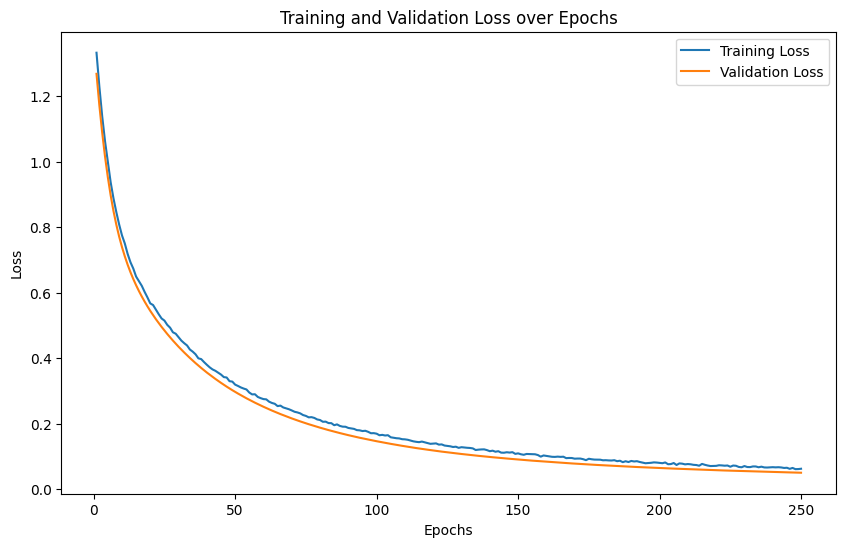

In [7]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are populated during training
num_epochs = len(train_losses)

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [8]:
def remove_padding(predictions, labels, padding_value=-100):
    valid_predictions = []
    valid_labels = []
    for pred, label in zip(predictions, labels):
        # Mask out the padding values
        valid_mask = (label != padding_value)
        valid_predictions.append(pred[valid_mask])
        valid_labels.append(label[valid_mask])
    return valid_predictions, valid_labels


# Final Evaluation on the Entire Dataset
test_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

def calc_accuracy(label,pred):
    lab = np.array(label, dtype = object)
    pre = np.array(pred, dtype = object)
    for i in range(len(lab)):
        elem1 = lab[i]
        if len(elem1) == 0:
            lab[i] = np.array([20])
    for i in range(len(pre)):
        elem1 = pre[i]
        if len(elem1) == 0:
            pre[i] = np.array([20])
    correct = np.sum(lab == pre)
    total = len(label) 
    return correct, total

# def eval_with_accuracy(model, dataloader, device, connect_dict):
#     model.eval()
#     total_loss = 0
#     correct_predictions = 0
#     total_predictions = 0
#     count = 0
#     with torch.no_grad():
#         for batch in tqdm(dataloader):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)
#             sentence_ids = batch['sentence_id']
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#             predictions = torch.argmax(logits, dim=-1)

#             # Move predictions and labels to CPU for further processing
#             predictions = predictions.cpu().numpy()
#             labels = labels.cpu().numpy()
# #             if count <= 2:
# #                 print(input_ids.shape)
# #                 print(labels.shape)
# #                 print(predictions.shape)
# #                 count+= 1
#             entity_tokens = []
# #             pred = predictions.tolist()
#             try:
#                 for i, labela in enumerate(predictions):
#                     try:
#                         # Find the start and end index of the entity
#                         start_idx = (labela == 1).nonzero()[0].item() - 1
#                         end_idx = (labela == 2).nonzero()[0].item() + 1

#                         # Extract the input_ids corresponding to these tokens
#                         entity_token_ids = input_ids[0][start_idx + 1:end_idx]

#                         # Decode the token ids to words
#                         entity_tokens = tokenizer.decode(entity_token_ids)
#                     except Exception as e:
#                         print(f"An error occurred while processing prediction {labela} with sentence_id{sentence_ids}: {str(e)}")

#             except Exception as e:
#                 print(f"An unexpected error occurred: {str(e)}")
# #                         if label in [1, 2]:  
# #                             print(label)
# #                             token_id = input_ids[0][j].item()
# #                             token = tokenizer.decode([token_id])
# #                             entity_tokens.append(token)
# #                             print(token)
# #                 # Join the tokens back to form the words (taking care of tokenization artifacts like '##')
# #                 entities = tokenizer.convert_tokens_to_string(entity_tokens)

# #             print("Extracted Entities:", entities)
#             for j in sentence_ids:
#                 connect_dict[j] = entity_tokens
#             # Calculate accuracy for this batch
#             for pred, label in zip(predictions, labels):
#                 valid_pred, valid_label = remove_padding(pred, label)  # Remove padding
# #                 if count <= 20:
# #                     print(np.array(valid_pred, dtype = object))
# #                     print(np.array(valid_label, dtype = object))
# #                     count+=1
# #                 if count <= 20:
# #                     print(valid_label[0].shape)
# #                     print(valid_pred[0].shape)
# #                     print(len(valid_label),len(valid_pred))
#                 a,b = calc_accuracy(valid_label,valid_pred)
#                 correct_predictions += a
#                 total_predictions += b
# #                 correct_predictions += np.sum(np.array(valid_pred, dtype = object) == np.array(valid_label, dtype = object))
# #                 total_predictions += len(valid_label)  # Total tokens (not padded)
#     # Final accuracy
#     accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    
#     return accuracy

# # Evaluation with accuracy metric
# connect_dict = {}
# test_accuracy = eval_with_accuracy(model, test_loader, device, connect_dict)

# print(f'Testing Accuracy: {test_accuracy:.8f}')

In [9]:
# a = np.array([1,2,3])
# b = np.array([1,1,1])
# c = torch.tensor([3,5,6])
# print(c[a == b])

In [10]:
# print(connect_dict)

In [11]:
num_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

3076


In [12]:
torch.save(model.state_dict(), 'model.pth')

In [13]:
def eval_with_accuracy(model, dataloader, device, connect_dict):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    count = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            sentence_ids = batch['sentence_id']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Move predictions and labels to CPU for further processing
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()

            entity_tokens = []
            try:
                for i, labela in enumerate(predictions):
                    try:
                        start_positions = (labela == 1).nonzero()[0]
                        end_positions = (labela == 2).nonzero()[0]

                                # Handling multiple start and end positions
                        if len(start_positions) > 1:
                            start_idx = start_positions[0]  # First occurrence of 1             
                        elif len(start_positions) > 0:
                            start_idx = start_positions[0]

                        if len(end_positions) > 1:
                            end_idx = end_positions[-1]  # Last occurrence of 2
                        elif len(end_positions) > 0:
                            end_idx = end_positions[0]

                        # If either start or end position is not present, take all tokens of 1s and 2s
                        if len(start_positions) == 0 or len(end_positions) == 0:
                            all_positions = [j for j, x in enumerate(labela) if x in [1, 2]]
                            start_idx = min(all_positions)
                            end_idx = max(all_positions)

                                # Extract the input_ids corresponding to these tokens
                        entity_token_ids = input_ids[i][start_idx:end_idx + 1]

                                # Decode the token ids to words
                        entity_tokens = tokenizer.decode(entity_token_ids)
                    except Exception as e:
                          print(f"An error occurred while processing prediction {labela} with sentence_id {sentence_ids}: {str(e)}")


            except Exception as e:
                print(f"An unexpected error occurred: {str(e)}")
            
#             try:
#             for i, labela in enumerate(predictions):
# #                     try:
#                 start_positions = (labela == 1).nonzero()[0]
#                 end_positions = (labela == 2).nonzero()[0]

#                         # Handling multiple start and end positions
#                 if len(start_positions) > 1:
#                     start_idx = start_positions[0]  # First occurrence of 1             
#                 elif len(start_positions) > 0:
#                     start_idx = start_positions[0]

#                 if len(end_positions) > 1:
#                     end_idx = end_positions[-1]  # Last occurrence of 2
#                 elif len(end_positions) > 0:
#                     end_idx = end_positions[0]

#                 # If either start or end position is not present, take all tokens of 1s and 2s
#                 if len(start_positions) == 0 or len(end_positions) == 0:
#                     all_positions = [j for j, x in enumerate(labela) if x in [1, 2]]
#                     start_idx = min(all_positions)
#                     end_idx = max(all_positions)

#                         # Extract the input_ids corresponding to these tokens
#                 entity_token_ids = input_ids[i][start_idx:end_idx + 1]

#                         # Decode the token ids to words
#                 entity_tokens = tokenizer.decode(entity_token_ids)
# #                     except Exception as e:
# #                         print(f"An error occurred while processing prediction {labela} with sentence_id {sentence_ids}: {str(e)}")

# #             except Exception as e:
# #                 print(f"An unexpected error occurred: {str(e)}")

            for j in sentence_ids:
                connect_dict[j] = entity_tokens

            # Calculate accuracy for this batch
            for pred, label in zip(predictions, labels):
                valid_pred, valid_label = remove_padding(pred, label)  # Remove padding
                a, b = calc_accuracy(valid_label, valid_pred)
                correct_predictions += a
                total_predictions += b

    # Final accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

    return accuracy



# Evaluation with accuracy metric
connect_dict = {}
test_accuracy = eval_with_accuracy(model, test_loader, device, connect_dict)

print(f'Testing Accuracy: {test_accuracy:.8f}')

 60%|██████    | 1586/2626 [00:16<00:10, 94.74it/s]

An error occurred while processing prediction [0 0 0 0 0 0 0 0 0 0 0] with sentence_id [1576]: min() arg is an empty sequence


100%|██████████| 2626/2626 [00:27<00:00, 94.18it/s]

Testing Accuracy: 0.99220754


In [14]:
print(connect_dict)

{1: "Carl's Jr.", 2: "Carl's Jr.", 3: "Carl's Jr.", 4: "Carl's Jr.", 5: "Carl's Jr.", 6: "Carl's Jr. has the parent company CKE Restaurants", 7: 'Target Corporation', 8: 'Target Corporation', 9: 'Target Corporation', 10: 'Target Corporation', 11: 'Target Corporation', 12: 'Target Corporation', 13: 'Castrol', 14: 'Castrol', 15: 'Castrol', 16: 'Castrol', 17: 'Castrol', 18: 'Castrol', 19: 'Castrol', 20: 'Castrol', 21: 'Forever 21', 22: 'Forever 21', 23: 'Forever 21', 24: 'Forever 21', 25: 'Forever 21', 26: 'Mister Donut', 27: 'Mister Donut', 28: 'Mister Donut', 29: 'Mister Donut', 30: 'Mister Donut', 31: 'Calvin Klein Inc', 32: 'Calvin Klein Inc', 33: 'Calvin Klein Inc', 34: 'Calvin Klein Inc', 35: 'Calvin Klein Inc', 36: 'Calvin Klein Inc', 37: 'Calvin Klein Inc', 38: 'China Unicom', 39: 'China Unicom', 40: 'China Unicom', 41: 'China Unicom', 42: 'China Unicom', 43: 'China Unicom', 44: "Chili's", 45: "Chili's", 46: "Chili's", 47: "Chili's", 48: "Chili's", 49: 'H', 50: 'Hotto Motto', 51: 

In [15]:
with open('data.json', 'w') as json_file:
    json.dump(connect_dict, json_file)
